In [1]:
import pandas as pd
import warnings
import os
import numpy as np
from lifetimes.plotting import *
from lifetimes.utils import *
from datetime import datetime
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from hyperopt import hp, fmin, tpe, rand, SparkTrials, STATUS_OK, space_eval, Trials
from lifetimes import BetaGeoFitter
from lifetimes import ModifiedBetaGeoFitter
from lifetimes.fitters.gamma_gamma_fitter import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
from scipy.stats import gamma
import matplotlib.pyplot as plt
from scipy.stats import beta

In [2]:
df = pd.read_csv("2019-Oct.csv")
df1 = pd.read_csv("2019-Nov.csv")
df2 = pd.read_csv("2019-Dec.csv")
df3 = pd.read_csv("2020-Jan.csv")
df4 = pd.read_csv("2020-Feb.csv")
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,cart,5773203,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
1,2019-10-01 00:00:03 UTC,cart,5773353,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
2,2019-10-01 00:00:07 UTC,cart,5881589,2151191071051219817,NaN,lovely,13.48,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9
3,2019-10-01 00:00:07 UTC,cart,5723490,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
4,2019-10-01 00:00:15 UTC,cart,5881449,1487580013522845895,NaN,lovely,0.56,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9


In [3]:
df.shape, df1.shape, df2.shape, df3.shape, df4.shape

((4102283, 9), (4635837, 9), (3533286, 9), (1048575, 8), (1048575, 8))

In [4]:
total_df= pd.concat([df, df1, df2, df3, df4])
total_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14368556 entries, 0 to 1048574
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    float64
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 1.1+ GB


In [5]:
con1= (total_df['event_type']== 'purchase')
purchase_df = total_df.loc[con1]
purchase_df

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
202,2019-10-01 00:06:35 UTC,purchase,5619862,1.487580e+18,NaN,runail,5.32,474232307,445f2b74-5e4c-427e-b7fa-6e0a28b156fe
204,2019-10-01 00:06:35 UTC,purchase,5619866,1.487580e+18,NaN,runail,2.86,474232307,445f2b74-5e4c-427e-b7fa-6e0a28b156fe
205,2019-10-01 00:06:35 UTC,purchase,5696184,1.487580e+18,NaN,runail,2.38,474232307,445f2b74-5e4c-427e-b7fa-6e0a28b156fe
206,2019-10-01 00:06:35 UTC,purchase,5706784,1.487580e+18,NaN,runail,4.44,474232307,445f2b74-5e4c-427e-b7fa-6e0a28b156fe
207,2019-10-01 00:06:35 UTC,purchase,5723503,1.487580e+18,NaN,runail,2.62,474232307,445f2b74-5e4c-427e-b7fa-6e0a28b156fe
...,...,...,...,...,...,...,...,...,...
1048152,2020-02-07 17:29:48 UTC,purchase,5867084,1.487580e+18,NaN,de.lux,0.79,263914610,85aa8532-882e-4afb-99d4-7ab6326de97a
1048153,2020-02-07 17:29:48 UTC,purchase,5867085,1.487580e+18,NaN,de.lux,0.79,263914610,85aa8532-882e-4afb-99d4-7ab6326de97a
1048154,2020-02-07 17:29:48 UTC,purchase,5905704,1.487580e+18,NaN,NaN,10.63,263914610,85aa8532-882e-4afb-99d4-7ab6326de97a
1048471,2020-02-07 17:32:24 UTC,purchase,5877453,1.487580e+18,NaN,jessnail,54.29,611641199,856ad917-4bdd-d1b5-55ba-27925a7ea76d


In [6]:
df_total = purchase_df[['event_time','user_id','price']]
df_total

,event_time,user_id,price
202,2019-10-01 00:06:35 UTC,474232307,5.32
204,2019-10-01 00:06:35 UTC,474232307,2.86
205,2019-10-01 00:06:35 UTC,474232307,2.38
206,2019-10-01 00:06:35 UTC,474232307,4.44
207,2019-10-01 00:06:35 UTC,474232307,2.62
...,...,...,...
1048152,2020-02-07 17:29:48 UTC,263914610,0.79
1048153,2020-02-07 17:29:48 UTC,263914610,0.79
1048154,2020-02-07 17:29:48 UTC,263914610,10.63
1048471,2020-02-07 17:32:24 UTC,611641199,54.29


In [7]:
df_total['event_time_clean']=pd.to_datetime(df_total['event_time'])
df_total.drop(['event_time'],axis=1,inplace=True)

df_total = df_total.sort_values('event_time_clean')
df_total

,user_id,price,event_time_clean
202,474232307,5.32,2019-10-01 00:06:35+00:00
212,474232307,1.59,2019-10-01 00:06:35+00:00
210,474232307,2.38,2019-10-01 00:06:35+00:00
209,474232307,2.38,2019-10-01 00:06:35+00:00
208,474232307,2.62,2019-10-01 00:06:35+00:00
...,...,...,...
1048151,263914610,0.79,2020-02-07 17:29:48+00:00
1048152,263914610,0.79,2020-02-07 17:29:48+00:00
1048154,263914610,10.63,2020-02-07 17:29:48+00:00
1048471,611641199,54.29,2020-02-07 17:32:24+00:00


In [8]:
current_date = df_total['event_time_clean'].max()

metrics_df = summary_data_from_transaction_data(df_total
                                          , customer_id_col = 'user_id'
                                          , datetime_col = 'event_time_clean'
                                          , monetary_value_col='price'
                                          , observation_period_end=current_date)
metrics_df.head()

C:\Users\c\anaconda3\lib\site-packages\lifetimes\utils.py:291: UserWarning: Converting to Period representation will drop timezone information.
  pd.to_datetime(observation_period_end, format=datetime_format).to_period(freq).to_timestamp()
C:\Users\c\anaconda3\lib\site-packages\lifetimes\utils.py:203: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  transactions = transactions.set_index(datetime_col).to_period(freq).to_timestamp()


,frequency,recency,T,monetary_value
user_id,,,,
9794320,0.0,0.0,74.0,0.00
10079204,0.0,0.0,93.0,0.00
10280338,1.0,1.0,79.0,29.57
12055855,0.0,0.0,49.0,0.00
15400971,0.0,0.0,56.0,0.00


In [9]:
current_clv = metrics_df
total_transaction=df_total.groupby('user_id').agg({'user_id': lambda x: x.count(),
                                        'price': lambda x: x.sum()})

total_transaction.columns = ['total_transaction', 'total_price']
total_transaction

,total_transaction,total_price
user_id,,
9794320,4,12.68
10079204,2,25.81
10280338,16,54.83
12055855,4,16.54
15400971,3,35.71
...,...,...
611722044,3,14.29
611729512,1,2.78
611733099,9,22.44


In [10]:
current_clv = pd.concat([current_clv, total_transaction], axis=1) 
current_clv

,frequency,recency,T,monetary_value,total_transaction,total_price
user_id,,,,,,
9794320,0.0,0.0,74.0,0.00,4,12.68
10079204,0.0,0.0,93.0,0.00,2,25.81
10280338,1.0,1.0,79.0,29.57,16,54.83
12055855,0.0,0.0,49.0,0.00,4,16.54
15400971,0.0,0.0,56.0,0.00,3,35.71
...,...,...,...,...,...,...
611722044,0.0,0.0,0.0,0.00,3,14.29
611729512,0.0,0.0,0.0,0.00,1,2.78
611733099,0.0,0.0,0.0,0.00,9,22.44


In [11]:
current_clv[current_clv.total_transaction > 1].shape

(73507, 6)

In [12]:
con1 = (current_clv['total_transaction'] > 1)
repeat_rate = current_clv.loc[con1].shape[0] / current_clv.shape[0]
repeat_rate

0.8985966113297963

In [13]:
churn_rate = 1 - repeat_rate
churn_rate

0.10140338867020371

In [14]:
current_clv['profit_margin'] = current_clv['total_price'] * 0.10

current_clv['customer_value'] = (current_clv['monetary_value'] * current_clv["frequency"]) / churn_rate
current_clv
current_clv['cltv'] = current_clv['customer_value'] * current_clv['profit_margin']
current_clv

,frequency,recency,T,monetary_value,total_transaction,total_price,profit_margin,customer_value,cltv
user_id,,,,,,,,,
9794320,0.0,0.0,74.0,0.00,4,12.68,1.268,0.000000,0.000000
10079204,0.0,0.0,93.0,0.00,2,25.81,2.581,0.000000,0.000000
10280338,1.0,1.0,79.0,29.57,16,54.83,5.483,291.607612,1598.884536
12055855,0.0,0.0,49.0,0.00,4,16.54,1.654,0.000000,0.000000
15400971,0.0,0.0,56.0,0.00,3,35.71,3.571,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
611722044,0.0,0.0,0.0,0.00,3,14.29,1.429,0.000000,0.000000
611729512,0.0,0.0,0.0,0.00,1,2.78,0.278,0.000000,0.000000
611733099,0.0,0.0,0.0,0.00,9,22.44,2.244,0.000000,0.000000


In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(current_clv[["cltv"]])
current_clv["scaled_cltv"] = scaler.transform(current_clv[["cltv"]])
current_clv.sort_values(by="scaled_cltv", ascending=False).head()

,frequency,recency,T,monetary_value,total_transaction,total_price,profit_margin,customer_value,cltv,scaled_cltv
user_id,,,,,,,,,,
150318419,58.0,126.0,126.0,45.526897,265,2680.85,268.085,26040.155409,6.980975e+06,1.000000
557790271,1.0,5.0,86.0,2565.900000,438,2715.87,271.587,25303.888101,6.872207e+06,0.984419
531900924,37.0,128.0,128.0,67.185135,211,2498.23,249.823,24514.466751,6.124278e+06,0.877281
565036131,3.0,90.0,93.0,716.413333,255,2555.82,255.582,21194.952439,5.417048e+06,0.775974
471197852,32.0,119.0,119.0,60.651562,249,2035.13,203.513,19139.892911,3.895217e+06,0.557977


In [16]:
current_clv.insert(10, 'segment', 0) 

current_clv.loc[current_clv['scaled_cltv'] <= 0.25, 'segment'] = 'a'
current_clv.loc[(current_clv['scaled_cltv'] > 0.25) & (current_clv['scaled_cltv'] <= 0.50), 'segment'] = 'b'
current_clv.loc[(current_clv['scaled_cltv'] > 0.50) & (current_clv['scaled_cltv'] <= 0.75), 'segment'] = 'c'
current_clv.loc[current_clv['scaled_cltv'] > 0.75, 'segment'] = 'g'

current_clv

,frequency,recency,T,monetary_value,total_transaction,total_price,profit_margin,customer_value,cltv,scaled_cltv,segment
user_id,,,,,,,,,,,
9794320,0.0,0.0,74.0,0.00,4,12.68,1.268,0.000000,0.000000,0.000003,a
10079204,0.0,0.0,93.0,0.00,2,25.81,2.581,0.000000,0.000000,0.000003,a
10280338,1.0,1.0,79.0,29.57,16,54.83,5.483,291.607612,1598.884536,0.000232,a
12055855,0.0,0.0,49.0,0.00,4,16.54,1.654,0.000000,0.000000,0.000003,a
15400971,0.0,0.0,56.0,0.00,3,35.71,3.571,0.000000,0.000000,0.000003,a
...,...,...,...,...,...,...,...,...,...,...,...
611722044,0.0,0.0,0.0,0.00,3,14.29,1.429,0.000000,0.000000,0.000003,a
611729512,0.0,0.0,0.0,0.00,1,2.78,0.278,0.000000,0.000000,0.000003,a
611733099,0.0,0.0,0.0,0.00,9,22.44,2.244,0.000000,0.000000,0.000003,a


In [17]:
current_clv['segment'].value_counts()

a    81792
b        5
g        4
c        1
Name: segment, dtype: int64

In [18]:
current_clv[["total_transaction", "total_price", "cltv", "scaled_cltv"]].sort_values(by="scaled_cltv",ascending=False).head()
current_clv.groupby('segment')[['total_transaction','total_price','cltv','scaled_cltv']].agg({'count','mean','sum'})

total_transaction                    total_price                      \
                      sum  count        mean         sum  count         mean   
segment                                                                        
a                  896497  81792   10.960693  4394698.18  81792    53.730171   
b                    1403      5  280.600000     8822.95      5  1764.590000   
c                     249      1  249.000000     2035.13      1  2035.130000   
g                    1169      4  292.250000    10450.77      4  2612.692500   

                 cltv                      scaled_cltv                   
                  sum  count          mean         sum  count      mean  
segment                                                                  
a        3.011668e+08  81792  3.682106e+03   43.370701  81792  0.000530  
b        1.399528e+07      5  2.799057e+06    2.004783      5  0.400957  
c        3.895217e+06      1  3.895217e+06    0.557977      1  0.557977  
g        2.539451e+07      4  6.348627e+06    3.637675      4  0.909419

BetaGeoFitter와 GammaGammaFitter를 사용하여 미래의 clv를 예측

In [19]:
current_date = df_total['event_time_clean'].max()

metrics_df = summary_data_from_transaction_data(df_total
                                          , customer_id_col = 'user_id'
                                          , datetime_col = 'event_time_clean'
                                          , monetary_value_col='price'
                                          , observation_period_end=current_date)
metrics_df.head()

C:\Users\c\anaconda3\lib\site-packages\lifetimes\utils.py:291: UserWarning: Converting to Period representation will drop timezone information.
  pd.to_datetime(observation_period_end, format=datetime_format).to_period(freq).to_timestamp()
C:\Users\c\anaconda3\lib\site-packages\lifetimes\utils.py:203: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  transactions = transactions.set_index(datetime_col).to_period(freq).to_timestamp()


,frequency,recency,T,monetary_value
user_id,,,,
9794320,0.0,0.0,74.0,0.00
10079204,0.0,0.0,93.0,0.00
10280338,1.0,1.0,79.0,29.57
12055855,0.0,0.0,49.0,0.00
15400971,0.0,0.0,56.0,0.00


In [20]:
max(df_total['event_time_clean']) - min(df_total['event_time_clean'])

Timedelta('129 days 17:25:49')

In [21]:
holdout_days = 30
calibration_end_date = current_date - timedelta(days = holdout_days)

metrics_cal_df = calibration_and_holdout_data(df_total
                                          ,customer_id_col = 'user_id'
                                          ,datetime_col = 'event_time_clean'
                                          ,calibration_period_end=calibration_end_date # train 데이터 기간
                                          ,observation_period_end=current_date         # 끝 기간
                                          ,freq='D'
                                          ,monetary_value_col='price')

metrics_cal_df.head()

C:\Users\c\anaconda3\lib\site-packages\lifetimes\utils.py:291: UserWarning: Converting to Period representation will drop timezone information.
  pd.to_datetime(observation_period_end, format=datetime_format).to_period(freq).to_timestamp()
C:\Users\c\anaconda3\lib\site-packages\lifetimes\utils.py:203: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  transactions = transactions.set_index(datetime_col).to_period(freq).to_timestamp()
C:\Users\c\anaconda3\lib\site-packages\lifetimes\utils.py:87: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  return d.to_period(freq)
C:\Users\c\anaconda3\lib\site-packages\lifetimes\utils.py:87: UserWarning: Converting to Period representation will drop timezone information.
  return d.to_period(freq)


,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
user_id,,,,,,,
9794320,0.0,0.0,44.0,0.00,0.0,0.0,30.0
10079204,0.0,0.0,63.0,0.00,0.0,0.0,30.0
10280338,1.0,1.0,49.0,29.57,0.0,0.0,30.0
12055855,0.0,0.0,19.0,0.00,0.0,0.0,30.0
15400971,0.0,0.0,26.0,0.00,0.0,0.0,30.0


In [22]:
## frequency가 0인 것은 제외하기
whole_filtered_df = metrics_df[metrics_df.frequency > 0]
filtered_df= metrics_cal_df[metrics_cal_df.frequency_cal > 0]

In [23]:
from hyperopt import hp, fmin, tpe, rand, SparkTrials, STATUS_OK, space_eval, Trials
from lifetimes import BetaGeoFitter
from lifetimes import ModifiedBetaGeoFitter
from lifetimes.fitters.gamma_gamma_fitter import GammaGammaFitter

# 평가 지표: default는 MSE
def score_model(actuals, predicted, metric='mse'):

    metric = metric.lower()

    # MSE / RMSE
    if metric=='mse' or metric=='rmse':
        val = np.sum(np.square(actuals-predicted))/actuals.shape[0]
    elif metric=='rmse':
        val = np.sqrt(val)
    # MAE
    elif metric=='mae':
        val = np.sum(np.abs(actuals-predicted))/actuals.shape[0]
    else:
        val = None

    return val

# BG/NBD 모형 평가
def evaluate_bgnbd_model(param):

    data   = inputs
    l2_reg = param

    # 모형 적합
    model = BetaGeoFitter(penalizer_coef=l2_reg)
    model.fit(data['frequency_cal'], data['recency_cal'], data['T_cal'])

    # 모형 평가
    frequency_actual = data['frequency_holdout']
    frequency_predicted = model.predict(data['duration_holdout']
                                        , data['frequency_cal']
                                        , data['recency_cal']
                                        , data['T_cal']
                                       )
    mse = score_model(frequency_actual, frequency_predicted, 'mse')

    return {'loss': mse, 'status': STATUS_OK}

# ModifiedBG/NBD 모형 평가
def evaluate_mbgnbd_model(param):

    data   = inputs
    l2_reg = param

    # 모형 적합
    model = ModifiedBetaGeoFitter(penalizer_coef=l2_reg)
    model.fit(data['frequency_cal'], data['recency_cal'], data['T_cal'])

    # 모형 평가
    frequency_actual = data['frequency_holdout']
    frequency_predicted = model.predict(data['duration_holdout']
                                        , data['frequency_cal']
                                        , data['recency_cal']
                                        , data['T_cal']
                                       )
    mse = score_model(frequency_actual, frequency_predicted, 'mse')

    return {'loss': mse, 'status': STATUS_OK}

# Gamma/Gamma 모델 평가
def evaluate_gg_model(param):

    data   = inputs
    l2_reg = param

    # GammaGamma 모형 적합
    model = GammaGammaFitter(penalizer_coef=l2_reg)
    model.fit(data['frequency_cal'], data['monetary_value_cal'])

    # 모형 평가
    monetary_actual = data['monetary_value_holdout']
    monetary_predicted = model.conditional_expected_average_profit(data['frequency_holdout'], data['monetary_value_holdout'])
    mse = score_model(monetary_actual, monetary_predicted, 'mse')

    # return score and status
    return {'loss': mse, 'status': STATUS_OK}

In [24]:
search_space = hp.uniform('l2', 0.0, 1.0)
algo = tpe.suggest 
trials = Trials() #저장할 객체
inputs = filtered_df

argmin = fmin(
  fn = evaluate_bgnbd_model, #목적함수
  space = search_space, #파라미터 공간
  algo = algo,  ## 베이지안 최적화 적용 알고리즘
  max_evals=100,   ## 입력 시도 횟수
  trials=trials   ## 시도한 입력 값 및 입력 결과 저장
  )

l2_bgnbd = space_eval(search_space,argmin) #search_space가 최소가 되는 값을 찾음
print(l2_bgnbd)

100%|████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.01trial/s, best loss: 0.19949997905556]
0.0001488661677053381


In [25]:
filtered_df_2 = filtered_df[filtered_df['monetary_value_cal']> 0]

search_space = hp.uniform('l2', 0.0, 1.0)
algo = tpe.suggest 
trials = Trials()
inputs = filtered_df_2

# GammaGamma
argmin = fmin(
  fn = evaluate_gg_model,
  space = search_space,
  algo = algo,
  max_evals=100,
  trials=trials
  )

l2_gg = space_eval(search_space,argmin)
print(l2_gg)

100%|███████████████████████████████████████████████| 100/100 [00:05<00:00, 18.47trial/s, best loss: 17.19836802699034]
0.07516582259089219


In [26]:
lifetimes_model = BetaGeoFitter(penalizer_coef=l2_bgnbd)
lifetimes_model.fit(filtered_df['frequency_cal'], filtered_df['recency_cal'], filtered_df['T_cal'])

# 모델 평가
frequency_actual = filtered_df['frequency_holdout']
frequency_predicted = lifetimes_model.predict(filtered_df['duration_holdout']
                                    ,filtered_df['frequency_cal'], filtered_df['recency_cal'], filtered_df['T_cal'])
mse = score_model(frequency_actual, frequency_predicted, 'mse')
rmse = np.sqrt(mse)
print('MSE: {0}'.format(mse))
print('RMSE: {0}'.format(rmse))

MSE: 0.19949997905556
RMSE: 0.44665420523662375


<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

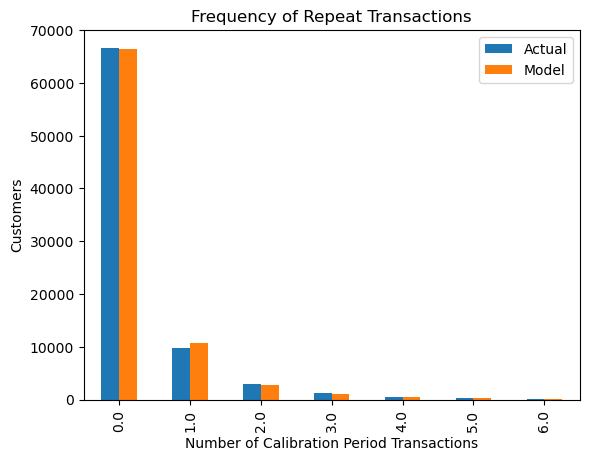

In [27]:
lifetimes_model = BetaGeoFitter(penalizer_coef=l2_bgnbd)
lifetimes_model.fit(metrics_df['frequency'], metrics_df['recency'], metrics_df['T'])


from lifetimes.plotting import plot_period_transactions
plot_period_transactions(lifetimes_model)


In [28]:
lifetimes_model.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.142982,0.002303,0.138468,0.147495
alpha,21.166327,0.555074,20.078382,22.254272
a,1.240651,0.056176,1.130546,1.350757
b,1.586608,0.081065,1.427720,1.745497


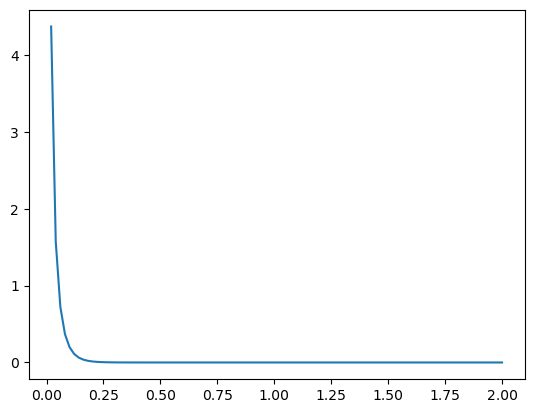

In [29]:
# 고객별 lambda (구매율) 의 분포
from scipy.stats import gamma
import matplotlib.pyplot as plt

coefs = lifetimes_model.summary['coef']
x = np.linspace (0, 2, 100) 
y = gamma.pdf(x, a=coefs['r'], scale=1/coefs['alpha'])

plt.plot(x, y)

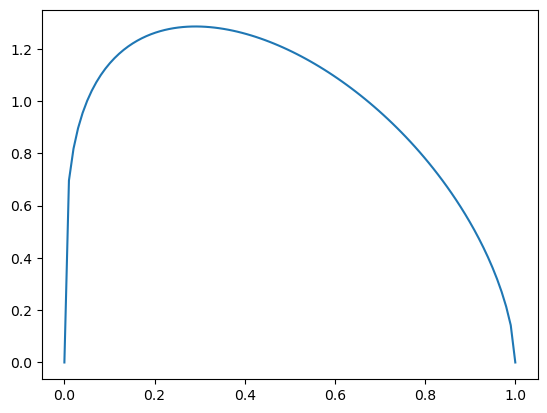

In [30]:
# 이탈률 p의 분포
from scipy.stats import beta
x = np.linspace (0, 1, 100) 
y = beta.pdf(x, a=coefs['a'], b=coefs['b'])

plt.plot(x,y)

In [31]:
spend_model = GammaGammaFitter(penalizer_coef=l2_gg)
spend_model.fit(filtered_df_2['frequency_cal'], filtered_df_2['monetary_value_cal'])
spend_model.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,1.486191,0.015349,1.456106,1.516275
q,0.350647,0.003416,0.343952,0.357341
v,1.313446,0.015830,1.282420,1.344472


In [32]:
# conditional_expected_average_profit: 고객별 평균 구매 금액 예측
monetary_actual = filtered_df['monetary_value_holdout']
monetary_predicted = spend_model.conditional_expected_average_profit(filtered_df['frequency_holdout']
                                                                    ,filtered_df['monetary_value_holdout'])

mse = score_model(monetary_actual, monetary_predicted, 'mse')
rmse = np.sqrt(mse)
print('MSE: {0}'.format(mse))
print('RMSE: {0}'.format(rmse))

MSE: 17.1977803932987
RMSE: 4.147020664681899


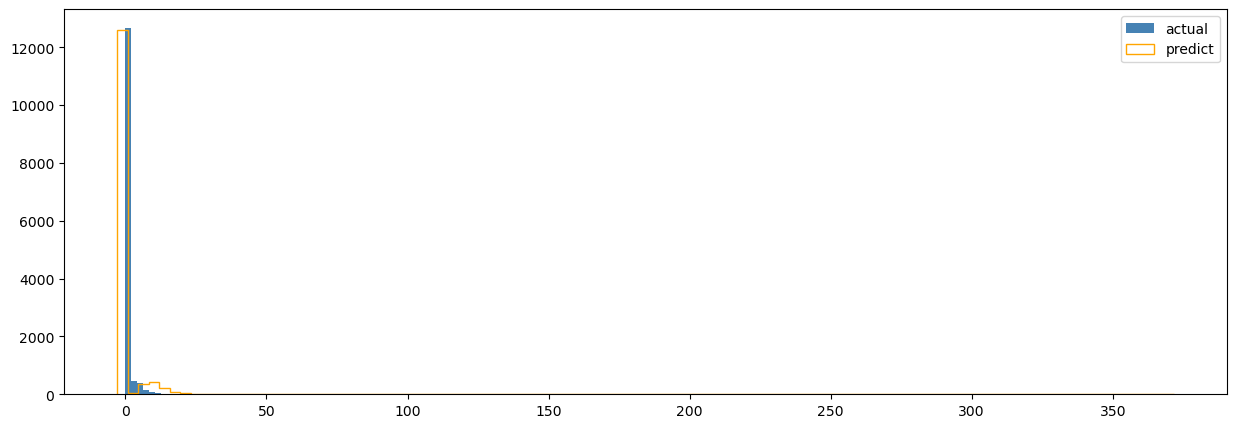

In [33]:
bins = 100
plt.figure(figsize=(15, 5))

plt.hist(monetary_actual, bins, label='actual', histtype='bar', color='STEELBLUE', rwidth=0.99)
plt.hist(monetary_predicted, bins, label='predict', histtype='step', color='ORANGE',  rwidth=0.99)
plt.legend(loc='upper right')

In [34]:
# LTV 구하기
# customer_lifetime_value 함수

final_df = whole_filtered_df.copy() #나누지 않은 데이터셋
final_df['ltv'] = spend_model.customer_lifetime_value(lifetimes_model,
                                                     final_df['frequency'],
                                                     final_df['recency'],
                                                     final_df['T'],
                                                     final_df['monetary_value'],
                                                     time = 12, # monthly
                                                     discount_rate=0.01 
                                                     )

t=365
final_df['predicted_purchases'] = lifetimes_model.conditional_expected_number_of_purchases_up_to_time(t
                                                                                      , final_df['frequency']
                                                                                     , final_df['recency']
                                                                                     , final_df['T'])

final_df['predicted_monetary_value'] = spend_model.conditional_expected_average_profit(final_df['frequency']
                                                                    ,final_df['monetary_value'])


In [35]:
final_df.sort_values(by="ltv").tail(5)

,frequency,recency,T,monetary_value,ltv,predicted_purchases,predicted_monetary_value
user_id,,,,,,,
247216055,42.0,125.0,127.0,43.840000,1838.254453,43.881002,44.332462
471197852,32.0,119.0,119.0,60.651562,2039.217997,35.055122,61.532770
531900924,37.0,128.0,128.0,67.185135,2528.428329,39.340110,68.023913
565036131,3.0,90.0,93.0,716.413333,2675.134722,3.377885,839.052004
150318419,58.0,126.0,126.0,45.526897,2699.316405,62.229979,45.895280


In [36]:
# 고객 순위 매기기
final_df.sort_values(by="ltv", ascending= False)

,frequency,recency,T,monetary_value,ltv,predicted_purchases,predicted_monetary_value
user_id,,,,,,,
150318419,58.0,126.0,126.0,45.526897,2699.316405,62.229979,45.895280
565036131,3.0,90.0,93.0,716.413333,2675.134722,3.377885,839.052004
531900924,37.0,128.0,128.0,67.185135,2528.428329,39.340110,68.023913
471197852,32.0,119.0,119.0,60.651562,2039.217997,35.055122,61.532770
247216055,42.0,125.0,127.0,43.840000,1838.254453,43.881002,44.332462
...,...,...,...,...,...,...,...
566418129,8.0,16.0,73.0,18.086250,0.773829,0.042284,19.304772
566588347,6.0,9.0,98.0,48.225000,0.466621,0.009449,52.248699
549445991,5.0,12.0,129.0,23.250000,0.287507,0.011840,25.764082


In [37]:
final_df['seg'] = pd.qcut(final_df['ltv'], q=4, labels=['a', 'b', 'c', 'd'])
final_df

,frequency,recency,T,monetary_value,ltv,predicted_purchases,predicted_monetary_value,seg
user_id,,,,,,,,
10280338,1.0,1.0,79.0,29.57,20.059669,0.388370,54.847810,a
29025780,1.0,5.0,128.0,23.62,10.173000,0.244793,44.280839,a
34080306,1.0,43.0,100.0,10.95,14.634024,0.714700,21.779407,a
34615712,1.0,11.0,87.0,9.59,8.832320,0.484679,19.364100,a
37189384,1.0,50.0,100.0,20.16,27.522405,0.767640,38.136012,b
...,...,...,...,...,...,...,...,...
610780487,1.0,1.0,1.0,22.14,92.080918,2.314565,41.652416,d
610829217,1.0,1.0,1.0,40.99,166.088181,2.314565,75.129290,d
610900967,1.0,1.0,2.0,24.63,98.045857,2.228872,46.074560,d


In [38]:
final_df.groupby('seg')[['ltv','predicted_purchases','predicted_monetary_value']].agg({'count','mean','sum'})

ltv                   predicted_purchases                  \
               sum count        mean                 sum count      mean   
seg                                                                        
a     51339.310170  3776   13.596216         2180.039665  3776  0.577341   
b    117613.300188  3776   31.147590         2988.510438  3776  0.791449   
c    216681.798330  3775   57.399152         3922.177310  3775  1.038987   
d    650712.210225  3776  172.328446         8277.238283  3776  2.192065   

    predicted_monetary_value                    
                         sum count        mean  
seg                                             
a              107019.491211  3776   28.342026  
b              194291.263651  3776   51.454254  
c              283989.174832  3775   75.228920  
d              451685.361523  3776  119.620064